## Install Required Libraries

In [2]:
!pip install numpy scikit-learn pyts torch matplotlib sktime==0.30.0 --quiet
!pip install git+https://github.com/gon-uri/detach_rocket --quiet

## Download Dataset from UCR

In [3]:
from detach_rocket.utils_datasets import fetch_ucr_dataset

# Download Dataset
dataset_name_list = ['FordB'] # PhalangesOutlinesCorrect ProximalPhalanxOutlineCorrect #Fordb
current_dataset = fetch_ucr_dataset(dataset_name_list[0])

## Prepare Dataset Matrices

In [5]:
import numpy as np

# Create data matrices and remove possible rows with nans

print(f"Dataset Matrix Shape: ( # of instances , time series length )")
print(f" ")

# Train Matrix
X_train = current_dataset['data_train']
print(f"Train: {X_train.shape}")
non_nan_mask_train = ~np.isnan(X_train).any(axis=1)
non_inf_mask_train = ~np.isinf(X_train).any(axis=1)
mask_train = np.logical_and(non_nan_mask_train,non_inf_mask_train)
X_train = X_train[mask_train]
X_train = X_train.reshape(X_train.shape[0],1,X_train.shape[1])
y_train = current_dataset['target_train']
y_train = y_train[mask_train]

print(f" ")

# Test Matrix
X_test = current_dataset['data_test']
#print(f"Number of test instances: {len(X_test)}")
print(f"Test: {X_test.shape}")
non_nan_mask_test = ~np.isnan(X_test).any(axis=1)
non_inf_mask_test = ~np.isinf(X_test).any(axis=1)
mask_test = np.logical_and(non_nan_mask_test,non_inf_mask_test)
X_test = X_test[mask_test]
X_test = X_test.reshape(X_test.shape[0],1,X_test.shape[1])
y_test = current_dataset['target_test']
y_test = y_test[mask_test]

Dataset Matrix Shape: ( # of instances , time series length )
 
Train: (3636, 500)
 
Test: (810, 500)


## Train and Evaluate the Model

In [6]:
from detach_rocket.detach_classes import DetachRocket

np.random.seed(2)

# Select initial model characteristics
model_type = "rocket"
num_kernels = 10000

# Create model object
DetachRocketModel = DetachRocket(model_type, num_kernels=num_kernels)

# Trian Model
DetachRocketModel.fit(X_train,y_train)

# Evaluate Performance on Test Set
detach_test_score, full_test_score= DetachRocketModel.score(X_test,y_test)
print('Test Accuraccy Full Model: {:.2f}%'.format(100*full_test_score))
print('Test Accuraccy Detach-ROCKET: {:.2f}%'.format(100*detach_test_score))

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


TRAINING RESULTS Full ROCKET:
Optimal Alpha Full ROCKET: 4832.93
Train Accuraccy Full ROCKET: 99.81%
-------------------------
TRAINING RESULTS Detach Model:
Optimal Alpha Detach Model: 3.36
Train Accuraccy Detach Model: 95.24%
-------------------------
Test Accuraccy Full Model: 81.11%
Test Accuraccy Detach-ROCKET: 81.73%


## Plot SFD Curve and Optimal Model Selection

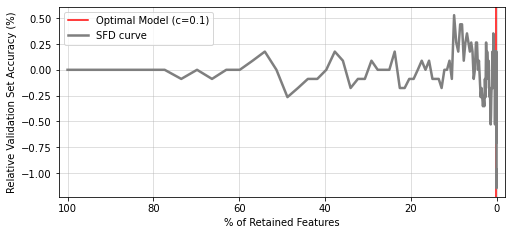

Optimal Model Size: 0.20% of full model


In [8]:
import matplotlib.pyplot as plt

percentage_vector = DetachRocketModel._percentage_vector
acc_curve = DetachRocketModel._sfd_curve

c = DetachRocketModel.trade_off

x=(percentage_vector) * 100
y=(acc_curve/acc_curve[0]-1) * 100

point_x = x[DetachRocketModel._max_index]
#point_y = y[DetachRocketModel._max_index]

plt.figure(figsize=(8,3.5))
plt.axvline(x = point_x, color = 'r',label=f'Optimal Model (c={c})')
plt.plot(x, y, label='SFD curve', linewidth=2.5, color='C7', alpha=1)
#plt.scatter(point_x, point_y, s=50, marker='o', label=f'Optimal point (c={c})')

plt.grid(True, linestyle='-', alpha=0.5)
plt.xlim(102,-2)
plt.xlabel('% of Retained Features')
plt.ylabel('Relative Validation Set Accuracy (%)')
plt.legend()
plt.show()

print('Optimal Model Size: {:.2f}% of full model'.format(point_x))